### 代码结构

In [3]:
import cv2
from Detector.SiftDetector import SiftDetector

In [4]:
cv2.__version__
filename = "Test-Images\\1.jpeg"
image = cv2.imread(filename, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
origImage = image.copy()

sift = SiftDetector(image)
image = sift.image

匹配： 352
内点，即与给定单应性匹配的匹配项： 178


In [5]:
from math import sqrt
import cv2
import numpy as np

def Ransac(match_kp1, match_kp2):
    '''
    无聚类，RANSAC单次调用
    '''
    inliers1 = []
    inliers2 = []
    count, rec = 0, 0
    p1 = np.float32([kp1.pt for kp1 in match_kp1])
    p2 = np.float32([kp2.pt for kp2 in match_kp2])
    homography, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
    inliers_thresold = 2.5  
    # 使用距离阈值来确定具有相等性检查的变量
    # 如果第一个关键点到第二个关键点的投影距离小于阈值，则符合单应性模型。
    # 为内点创建新的匹配数据集，以绘制所需的匹配
    good_matches = []
    for i, m in enumerate(match_kp1):
        col = np.ones((3, 1), dtype=np.float64)
        col[0:2, 0] = m.pt
        col = np.dot(homography, col)
        col /= col[2, 0]
        # 单应性与点之间的距离计算
        distance = sqrt(pow(col[0, 0] - match_kp2[i].pt[0], 2) +
                        pow(col[1, 0] - match_kp2[i].pt[1], 2))
        if distance < inliers_thresold:
            count = count + 1
    if count * 2.5 < len(match_kp1):
        inliers_thresold = 339
        rec = 3
    for i, m in enumerate(match_kp1):
            col = np.ones((3, 1), dtype=np.float64)
            col[0:2, 0] = m.pt
            col = np.dot(homography, col)
            col /= col[2, 0]
            distance = sqrt(pow(col[0, 0] - match_kp2[i].pt[0], 2) +
                        pow(col[1, 0] - match_kp2[i].pt[1], 2))
            if distance < inliers_thresold:
                good_matches.append(cv2.DMatch(len(inliers1), len(inliers2), 0))
                inliers1.append(match_kp1[i])
                inliers2.append(match_kp2[i])
    print("匹配：", len(match_kp1))
    print("内点，即与给定单应性匹配的匹配项：", len(inliers1))
    good_points1 = np.float32([kp1.pt for kp1 in inliers1])
    good_points2 = np.float32([kp2.pt for kp2 in inliers2])
    return good_points1, good_points2, rec

In [6]:
import cv2
import numpy as np
from scipy.spatial.distance import pdist

def Match_features(filename):
    image = cv2.imread(filename, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # origImage = image.copy() # 在绘制箭头和其它标识操作时，我们都是在原图（或其拷贝）上进行绘制，这些操作会直接修改图像数据。
    
    sift = cv2.SIFT_create()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    key_points, descriptors = sift.detectAndCompute(gray, None)
    distance = cv2.NORM_L2
    
    bf = cv2.BFMatcher(distance)
    # 进行 K 近邻匹配，返回最近的 10 个匹配项
    matches = bf.knnMatch(descriptors, descriptors, k=10) # 一个包含多个 DMatch 对象的列表
    # Lowe 比例测试的阈值
    ratio = 0.6
    mkp1, mkp2 = [], []
    for m in matches:
        j = 1
        while m[j].distance < ratio * m[j + 1].distance:
            j = j + 1
        for k in range(1, j):
            temp = m[k]
            # 只有当距离大于 10 像素时，才认为这是一个有效的匹配，防止匹配到自己
            if pdist(np.array([key_points[temp.queryIdx].pt,
                            key_points[temp.trainIdx].pt])) > 10:
                mkp1.append(key_points[temp.queryIdx])
                mkp2.append(key_points[temp.trainIdx])
    # remove the false matches
    return Ransac(mkp1, mkp2)

In [7]:
import os

def showResult(filename,good_points1, good_points2,toShowTampered=False):
    image = cv2.imread(filename, cv2.IMREAD_COLOR)
    # good_points1 和 good_points2 已经是一一对应的点数组
    for pt1, pt2 in zip(good_points1, good_points2):
        start_point = (int(pt1[0]), int(pt1[1]))
        end_point = (int(pt2[0]), int(pt2[1]))
        # 绘制从起点到终点的箭头
        cv2.arrowedLine(image, start_point, end_point, (0, 255, 0), 1, 1, tipLength=0.1)
        # 绘制起点和终点的小圆点
        cv2.circle(image, start_point, 3, (255, 0, 0), -1)
        cv2.circle(image, end_point, 3, (255, 0, 0), -1)

    # 显示原图中的凸包标识
    hull1 = cv2.convexHull(np.int32(good_points1))
    cv2.polylines(image, [hull1], True, (255, 0, 0), 3)
    # 显示原图中的凸包标识
    hull2 = cv2.convexHull(np.int32(good_points2))
    cv2.polylines(image, [hull2], True, (0, 0, 255), 3)

    # 调整图像大小
    scale_percent = 50  # 50% 缩放
    # width = int(image.shape[1] * scale_percent / 100)
    # height = int(image.shape[0] * scale_percent / 100)
    width = 800
    height = 600
    dim = (width, height)
    # resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    resized = image
    
    if toShowTampered :
        cv2.imshow("Copy-Move Arrows Resized", resized)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        result_folder = "result"
        if not os.path.exists(result_folder):
            os.makedirs(result_folder)

        # 构造保存路径，使用原图的文件名
        result_path = os.path.join(result_folder, os.path.basename(filename))

        # 保存图像（cv2.imwrite 保存的是 BGR 格式图像，如果你之前转换成 RGB，请转换回来）
        # Image 是 RGB 格式
        cv2.imwrite(result_path, cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))

In [8]:
if __name__=="__main__":
    toShowTampered = False
    filename = "Test-Images\\3.png"
    good_points1, good_points2, rec = Match_features(filename)  # match points
    showResult(filename,good_points1, good_points2)

匹配： 63
内点，即与给定单应性匹配的匹配项： 29


### 聚类改进

In [17]:
import numpy as np
import cv2
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from itertools import combinations
import matplotlib.pyplot as plt
import os

def HAC_SIFT(filename, metric='euclidean', thc=2.2, min_cluster_pts=4, plotimg=False,saveimg=False):
    # 读取并预处理图像
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # SIFT特征提取
    # sift = cv2.SIFT_create()
    sift = cv2.SIFT_create(
        contrastThreshold=0.1,  # 对比度阈值，用于滤除低对比度区域的特征
        edgeThreshold=50,       # 边缘阈值，用于排除边缘响应较强的点
    )
    key_points, descriptors = sift.detectAndCompute(gray, None)

    # 使用BFMatcher进行特征匹配
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(descriptors, descriptors, k=10)

    # Lowe's比例测试筛选匹配点对
    ratio_thresh = 0.6
    matched_kp1, matched_kp2 = [], []
    for match in matches:
        j = 1
        while j < len(match) - 1 and match[j].distance < ratio_thresh * match[j + 1].distance:
            temp = match[j]
            pt1, pt2 = key_points[temp.queryIdx].pt, key_points[temp.trainIdx].pt
            # 距离大于10像素防止自匹配
            if np.linalg.norm(np.array(pt1) - np.array(pt2)) > 10:
                matched_kp1.append(pt1)
                matched_kp2.append(pt2)
            j += 1

    if not matched_kp1:
        return 0, [], [], []

    # 准备聚类的数据
    points = np.vstack((matched_kp1, matched_kp2))

    # 层次聚类
    Z = linkage(pdist(points), method='single', metric=metric)
    clusters = fcluster(Z, t=thc, criterion='distance')

    # 初始化结果
    num_gt = 0
    inliers1, inliers2 = [], []
    cluster_labels = np.unique(clusters)

    # 可视化匹配点与聚类（可选）
    if plotimg:
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        for pt1, pt2 in zip(matched_kp1, matched_kp2):
            plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'c-', alpha=0.5)
        plt.scatter(points[:, 0], points[:, 1], c=clusters, cmap='jet', marker='o')
        plt.title('Hierarchical Clustering of SIFT Matches')
        plt.show()
    
    if saveimg:
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        for pt1, pt2 in zip(matched_kp1, matched_kp2):
            plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'c-', alpha=0.5)
        plt.scatter(points[:, 0], points[:, 1], c=clusters, cmap='jet', marker='o')
        plt.title('Hierarchical Clustering of SIFT Matches')
        if not os.path.exists('result'):
            os.makedirs('result')
        # filename 包含完整路径
        base_filename = os.path.basename(filename)  # 例如 "example.png"
        plt.savefig(f'result\\detect_{base_filename}')  # 保存图像到 output.png 文件
        plt.close()  # 关闭图像

    # 对每一对聚类分别计算单应性矩阵并筛选内点
    if len(cluster_labels) > 1:
        for cluster1, cluster2 in combinations(cluster_labels, 2):
            z1, z2 = [], []
            for idx in range(len(matched_kp1)):
                if clusters[idx] == cluster1 and clusters[idx + len(matched_kp1)] == cluster2:
                    z1.append(matched_kp1[idx])
                    z2.append(matched_kp2[idx])
                elif clusters[idx] == cluster2 and clusters[idx + len(matched_kp1)] == cluster1:
                    z1.append(matched_kp2[idx])
                    z2.append(matched_kp1[idx])

            if len(z1) > min_cluster_pts and len(z2) > min_cluster_pts:
                H, mask = cv2.findHomography(np.array(z1), np.array(z2), cv2.RANSAC, 0.05)
                if H is not None:
                    num_gt += 1
                    mask = mask.ravel().astype(bool)
                    inliers1.extend(np.array(z1)[mask].tolist())
                    inliers2.extend(np.array(z2)[mask].tolist())
    if num_gt>0:
        print("Tampering dected!")
    else:
        print("Image not tampered.")
    return num_gt, np.array(inliers1), np.array(inliers2)



In [10]:
if __name__=="__main__":
    toShowTampered = False
    filename = "Test-Images\\1.jpeg"
    # filename = "Test-Images\\3.png"
    num,good_points1, good_points2 = HAC_SIFT(filename,saveimg=True)  # match points
    if(num>1):
        print("tampered Detected!")
    else:
        print("Image not tampered.")
    # showResult(filename,good_points1, good_points2)

Image not tampered.
Image not tampered.


In [11]:
import numpy as np
import cv2
import os
from itertools import combinations
import matplotlib.pyplot as plt

# 若使用sklearn来做DBSCAN，需要先安装 scikit-learn
from sklearn.cluster import DBSCAN

def DBSCAN_SIFT(
    filename,
    eps=40,                # DBSCAN半径
    min_samples=2,         # DBSCAN最少点数
    ratio_thresh=0.6,      # Lowe’s Ratio Test阈值
    dist_thresh=10,        # 自匹配排除的距离阈值
    ela_quality=90,        # JPEG压缩品质
    ela_thresh=25,         # 对ELA差分结果的二值化阈值
    plotimg=False,         
    saveimg=False
):
    """
    依据原论文：Copy-Move image forgery detection and classification using 
    SIFT and DBSCAN Approaches 实现的核心流程示例。

    参数:
        filename      : 输入图像路径
        eps           : DBSCAN中的eps（邻域半径）
        min_samples   : DBSCAN中的min_samples
        ratio_thresh  : Lowe’s Ratio Test的比例阈值
        dist_thresh   : 排除与自身过近的匹配，避免自匹配
        ela_quality   : ELA时JPEG重新保存的压缩质量，原论文中示例取90
        ela_thresh    : ELA差分图做二值化时的阈值，可根据实际实验略作调节
        plotimg       : 是否可视化中间匹配点与最终检测结果

    返回:
        forged_image  : 标注了可疑伪造区域和原区域的图像
        keypoints     : 提取到的SIFT关键点
        clusters      : DBSCAN得到的聚类标签（与匹配点顺序对应）
        ela_mask      : 经过ELA后最终的二值化掩码
    """

    # 1) 读取并转换为灰度图
    image = cv2.imread(filename)
    if image is None:
        raise IOError(f"无法读取图片: {filename}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2) 提取SIFT特征
    sift = cv2.SIFT_create()
    key_points, descriptors = sift.detectAndCompute(gray, None)

    if descriptors is None or len(key_points) == 0:
        print("未检测到SIFT关键点。")
        return image, [], [], None

    # 3) BFMatcher进行特征匹配 + Ratio Test
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    # k=2 或 k>2均可，这里取 k=2 做标准的Ratio Test；也可设 k=10 再自行筛选
    matches_knn = bf.knnMatch(descriptors, descriptors, k=2)

    matched_kp1 = []
    matched_kp2 = []

    for m in matches_knn:
        # 确保取到至少两条匹配
        if len(m) < 2:
            continue
        m1, m2 = m[0], m[1]
        # Ratio Test
        if m1.distance < ratio_thresh * m2.distance:
            pt1 = key_points[m1.queryIdx].pt
            pt2 = key_points[m1.trainIdx].pt
            # 排除过近的自匹配
            if np.linalg.norm(np.array(pt1) - np.array(pt2)) > dist_thresh:
                matched_kp1.append(pt1)
                matched_kp2.append(pt2)

    if len(matched_kp1) == 0:
        print("未找到有效匹配对，可能图像无篡改或关键点不足。")
        return image, key_points, [], None

    # 4) 将匹配到的点(仅坐标)拼到一个数组中，准备做DBSCAN
    matched_kp1 = np.array(matched_kp1, dtype=np.float32)
    matched_kp2 = np.array(matched_kp2, dtype=np.float32)

    # 原论文做的是“将所有可疑点在同一空间聚类”或“分别聚类后对比”，
    # 这里示例将它们都放一起做一个整体聚类。(也可按需调试)
    all_points = np.concatenate((matched_kp1, matched_kp2), axis=0)

    # 5) DBSCAN聚类
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(all_points)

    # -1 表示噪点(Outliers)
    unique_labels = set(cluster_labels)
    if -1 in unique_labels:
        unique_labels.remove(-1)  # 不考虑噪点

    # 仅做演示：将每个簇的点画出来(可选)
    if plotimg:
        plt.figure(figsize=(8, 6))
        plt.scatter(all_points[:, 0], all_points[:, 1],
                    c=cluster_labels, cmap='rainbow', s=10)
        plt.title("DBSCAN Clustering on Matched Keypoints")
        plt.show()
    

    # 6) 基于 ELA (Error Level Analysis) 的伪造区域高亮
    # 6.1) 先将原图保存为JPEG质量=ela_quality
    temp_jpeg = "temp_ela.jpg"
    cv2.imwrite(temp_jpeg, image, [int(cv2.IMWRITE_JPEG_QUALITY), ela_quality])
    # 再读入压缩后的图
    compressed_img = cv2.imread(temp_jpeg)
    # 删除临时文件(可选)
    if os.path.exists(temp_jpeg):
        os.remove(temp_jpeg)

    # 6.2) 做绝对差分
    ela_diff = cv2.absdiff(image, compressed_img)

    # 6.3) 转为灰度再阈值化(聚焦强度差异)
    ela_diff_gray = cv2.cvtColor(ela_diff, cv2.COLOR_BGR2GRAY)
    _, ela_mask = cv2.threshold(ela_diff_gray, ela_thresh, 255, cv2.THRESH_BINARY)

    # 6.4) 找到差分区域的轮廓，然后进行可视化
    contours, _ = cv2.findContours(ela_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 在原图上标记
    forged_image = image.copy()

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # 在这里可以选择性判断一下w,h是否过大或过小，以过滤噪声
        # 这里只做简单演示，直接画框
        cv2.rectangle(forged_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # 这里也可结合 DBSCAN 的聚类结果，对不同簇打不同的颜色或标签
    # 本示例主要展示 ELA 产生的区域框。对原文而言，DBSCAN用于找拷贝的特征点对，
    # 而 ELA 用于进一步确定假区域 vs. 原区域。

    # 最终若需要展示处理后的图像：
    if plotimg:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].imshow(cv2.cvtColor(ela_diff, cv2.COLOR_BGR2RGB))
        axes[0].set_title("ELA 绝对差分图")
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(forged_image, cv2.COLOR_BGR2RGB))
        axes[1].set_title("在原图上标记怀疑区域")
        axes[1].axis("off")
        plt.show()

    return key_points, cluster_labels, ela_mask


总共读取到 220 个图像记录。
Processing: dataset\MICC-F220\CRW_4853tamp1.jpg (1/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4853tamp131.jpg (2/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4853tamp132.jpg (3/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4853tamp133.jpg (4/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4853tamp134.jpg (5/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4853tamp176.jpg (6/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4853tamp237.jpg (7/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4853tamp25.jpg (8/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4853tamp27.jpg (9/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4853tamp37.jpg (10/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4901_JFRtamp1.jpg (11/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4901_JFRtamp131.jpg (12/220)
Image not tampered.
Processing: dataset\MICC-F220\CRW_4901_JFRt

KeyboardInterrupt: 

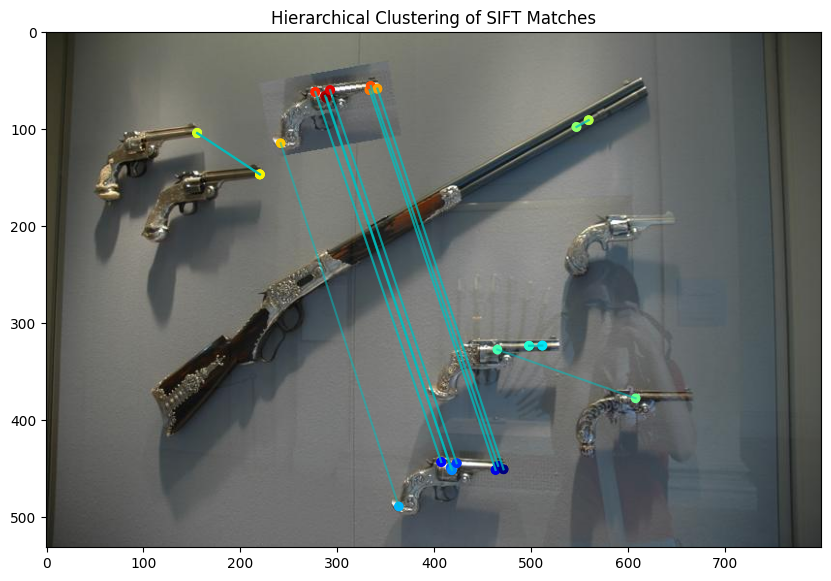

In [18]:
# run_F200_experiment

import os
import time

def run_experiment():
    # 1. 基础配置
    DB = 'MICC-F220'
    db_dir = 'dataset'
    file_ground_truth = 'groundtruthDB_220.txt'

    # 3. 读取 ground truth
    ground_truth_path = os.path.join(db_dir, DB, file_ground_truth)
    if not os.path.exists(ground_truth_path):
        raise FileNotFoundError(f"无法找到 ground truth 文件: {ground_truth_path}")

    # 期望文件格式: 
    # 每行内容为 "图像文件名 是否篡改(1或0)"
    # 例如: "image0001.png 1"
    with open(ground_truth_path, 'r') as f:
        lines = f.read().splitlines()

    # 储存文件名和标签信息
    image_info_list = []
    for line in lines:
        # 假设每行以空格分隔：图像名 + 0/1
        parts = line.split()
        if len(parts) != 2:
            continue
        img_name, tamper_label = parts[0], int(parts[1])
        image_info_list.append((img_name, tamper_label))

    num_images = len(image_info_list)
    print(f"总共读取到 {num_images} 个图像记录。")

    # 4. 初始化计数器
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    # 记录实验用时
    tstart = time.time()

    # 5. 逐图处理
    for i, (img_name, gt_label) in enumerate(image_info_list, start=1):
        loc_file = os.path.join(db_dir, DB, img_name)
        print(f"Processing: {loc_file} ({i}/{num_images})")

        # 调用 process_image 函数 (需您自行实现对应算法)
        # 若返回值 countTrasfGeom >=1，则认为该图检测到篡改
        countTrasfGeom,*_ = HAC_SIFT(loc_file,saveimg=True)
        # 与 ground truth 做比较
        detected_tampered = (countTrasfGeom >= 1)
        if detected_tampered:
            # 若检测结果为篡改
            if gt_label == 1:
                TP += 1
            else:
                FP += 1
        else:
            # 若检测结果为未篡改
            if gt_label == 1:
                FN += 1
            else:
                TN += 1

    # 6. 计算指标
    # TPR = TP / (TP + FN)
    # FPR = FP / (FP + TN)
    # 注意：若分母为0，需要做特殊处理以避免报错
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

    print("\nCopy-Move Forgery Detection performance:")
    print(f"TPR = {TPR*100:.2f}%")
    print(f"FPR = {FPR*100:.2f}%")

    # 7. 计算用时
    tproc = time.time() - tstart
    # 格式化输出时分秒
    hours = int(tproc // 3600)
    minutes = int((tproc % 3600) // 60)
    seconds = tproc % 60
    print(f"\nComputational time: {hours:02d}:{minutes:02d}:{seconds:04.1f}")


if __name__ == "__main__":
    run_experiment()
